In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
# Load data
train_data = np.genfromtxt('./data/sign_mnist_train.csv', delimiter=',')
test_data = np.genfromtxt('./data/sign_mnist_test.csv', delimiter=',')
y_train = train_data[:,0].reshape(-1,1)  # Shape: (m,1)
X_train = train_data[:, 1:] / 255       # Shape: (m, input_layer_size)

# y_test = train_data[:,0].reshape(-1,1)  # Shape: (m,1)
# X_test = train_data[:, 1:] / 255        # Shape: (m, input_layer_size)

# print(f'training examples: {np.shape(y_train)[0]}\ntesting examples: {np.shape(y_test)[0]}')

In [4]:
def layer_init(L_IN, L_OUT):
    # uniform dist
    ret = np.random.uniform(-1., 1., size=(L_IN,L_OUT))/np.sqrt(L_IN*L_OUT)
    return ret.astype(np.float32)

def return_labeled(y, num_labels):
    '''returns (m, num_labels) matrix of correct answers'''
    out = np.zeros((len(y), num_labels), np.float32)
    for example in range(0, len(y)):
        correct_answer = int(y[example])
        out[example, correct_answer] = 1
    return out

In [5]:
def ReLU(x):
    ''' 0: if x < 0
        x: otherwise
    '''
    return x * (x > 0).astype(np.float32)

def dx_ReLU(x):
    '''0: if x < 0
       1: otherwise
    '''
    return 1. * (x > 0).astype(np.float32)

def log_sum_exp(x):
    '''normalizing'''
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

In [28]:
def fwd_prop(X,y):
    # Forward Propogate:
    z2 = X.dot(theta1)                              # calculating layer 2 before activation
    a2_relu = ReLU(z2)                              # Activation of hidden layer using ReLU
    z3 = a2_relu.dot(theta2)                        # calculating layer3 (hidden layer 2)
    a3_relu = ReLU(z3)                              # Activation of hidden layer2 using ReLU
    z4 = a3_relu.dot(theta3)                        # Calculating layer4 (output layer)
    # Log sum softmax to normalize and calculate output
    log_sm = z4 - log_sum_exp(z4).reshape(-1,1)     # log sum normalizing z3: LOG SOFTMAX 
    return a2_relu, a3_relu, log_sm, z2, z3, z4

def backprop(out_label, a2, a3, a4):
    # Taking the dericative of log soft max: https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_prediction = out_label - np.exp(a4)*out_label.sum(axis=1).reshape((-1, 1))
    
    pass

def propogate(X,y):
    ''' handles forward and backwards propogation
    X size     : (m, input_layer_size)
    theta1 size: (input_layer_size, hidden_layer_size)
    theta2 size: (hidden_layer_size, num_labels) '''
    labels = return_labeled(y, num_labels) # (m, num_labels) of correct outputs
    
    # Forward propogation
    a2, a3, a4, z2, z3, z4 = fwd_prop(X,y) 

    # Calculating cost
    J = (-labels * a4).mean(axis=1)  # Calculating cost with log probs to normalize and avoid overflows
    d_out = -labels / len(y) # Replace 1 in each row of labeld with (-1/m), else 0
    # Back propogation
    
    # output layer -> hidden layer2
    gradient3 = a2_relu.T.dot(dx_log_sm)
    dx_relu = dx_log_sm.dot(theta3.T)
    
    # hidden layer2 -> hidden layer1
    dx_theta2 = dx_ReLU(a3_relu) * dx_relu     # derivative of relu
    gradient2 = a2_relu.T.dot(dx_theta2) # derivative of theta1
    
    # hidden layer1 -> input layer
    dx_theta1 = dx_ReLU(a2_relu) * dx_theta2     # derivative of relu
    gradient1 = X.T.dot(dx_theta1) # derivative of theta1
    
    
    return J, z4, gradient1, gradient2, gradient3
    

In [29]:
# Network Architecture
input_layer_size = 784   # (28,28) pixels
hidden_layer1_size = 120  # Hidden layer nodes
hidden_layer2_size = 120  # seccond hidden layer nodes
num_labels = 26          # letters [a=0 -> z=25]

np.random.seed(1420)
theta1 = layer_init(input_layer_size, hidden_layer1_size)   # (input_layer_size,hidden_layer_size)
theta2 = layer_init(hidden_layer1_size, hidden_layer2_size)
theta3 = layer_init(hidden_layer2_size, num_labels)        # (hidden_layer_size, num_labels)

learning_rate = 0.01  # (learning rate is so high because X matrix normalized from [0-255] -> [0,1], w/o norm: 0.001)
batch_size = 144
epochs = 1000

costs, accuracies = [], []


# cost, h, gradient1, gradient2, gradient3 = propogate(X,y) # fwd/back prop. returns (cost, predictions, theta1 grad, theta2 grad)

loss 0.12 accuracy 0.05: 100%|██████████| 1000/1000 [00:02<00:00, 342.35it/s]


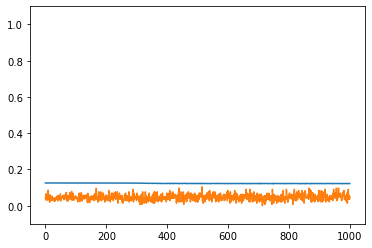

In [30]:
# Training logic
for i in (t := trange(epochs)):
    
    # Grabbing a random array of size batch size, indexes [0-m], m := # examples
    samples = np.random.randint(0, len(y_train), size=(batch_size))
    X = X_train[samples]                        # (m, pixel rows, pixel cols) -> (m, pixels)
    y = y_train[samples]                        # (m, ) vector of output 
    
    cost, h, gradient1, gradient2, gradient3 = propogate(X,y) # fwd/back prop. returns (cost, predictions, theta1 grad, theta2 grad)
    
    prediction = np.argmax(h, axis=1)
    accuracy = (prediction == y).mean()
    
    # Stoich grad descent
    theta1 = theta1 - (learning_rate * gradient1)
    theta2 = theta2 - (learning_rate * gradient2)
    theta3 = theta3 - (learning_rate * gradient3)
    
    cost = cost.mean()
    costs.append(cost)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (cost, accuracy))


# Displaying cost and accuracy over iterations
plt.ylim(-0.1, 1.1)
plt.plot(costs)
plt.plot(accuracies)


In [13]:
print(costs)

[0.125311491696219, 0.12531086940170238, 0.12531140284529985, 0.1253123421110125, 0.12530165693935497, 0.12529744750826521, 0.1252662888231414, 0.12520792109807888, 0.12508667313118638, 0.12493927666083682, 0.12439524239158543, 0.12417004164251819, 0.12474509947036043, 0.12336173395146405, 0.1246699902609459, 0.1240913416857458, 0.12288890879367363, 0.12593879190277807, 0.12491319054491529, 0.12355132126832803, 0.12243349916186647, 0.12567217956091742, 0.12506404578075447, 0.12434331388101239, 0.12224726292980106, 0.12463336229540789, 0.12438803055203608, 0.12435481611470071, 0.12350804075526474, 0.12399418869193715, 0.12359492644470363, 0.12441901424912397, 0.12333972070174887, 0.1236118639023057, 0.12443203421529352, 0.1235565121345445, 0.12285849287562901, 0.12319321161176308, 0.1226536084109717, 0.12406173860556821, 0.12400961230624809, 0.12388968235522577, 0.1235883196917892, 0.12358945622638891, 0.12300631693580666, 0.12399836069044835, 0.12475600839463682, 0.12391984284644492, 0